# Task Prioritization Models

**Business Objective (BO)**: Improve Task Prioritization  
**Goal**: Ensure high-priority tasks are completed on time.

**Models to implement**:
1. **KNN (Supervised - Classification)**:
   - Why? Compare tasks to historical ones (e.g., "Tasks like this had a 70% on-time completion rate")
   - Features: Priority, Progress, Hours Spent, Project Type
   - Target: Task Status (Binary: "Completed on time" vs. "Delayed")

2. **SVM (Supervised - Classification)**:
   - Why? Robust for small datasets; classify tasks by priority alignment
   - Features: Same as KNN

3. **Decision Tree (Optional)**:
   - Why? Explainable rules (e.g., "High-priority tasks with <20% progress after 1 week → delay risk")

**Output**:
- Priority-based task risk scores
- Alerts for misaligned priorities (e.g., High-Priority + Low Progress)

## 1. Import Libraries

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# KNN model
from sklearn.neighbors import KNeighborsClassifier

# SVM model
from sklearn.svm import SVC

# Decision Tree model
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('modified_project_management_dataset.csv')

# Display the first few rows
df.head()

,Project ID,Project Name,Project Type,Start Date,End Date,Project Status,Priority,Task ID,Task Name,Task Status,Assigned To,Hours Spent,Progress
0,P001,Renovation of a School Project 001,Renovation,21/07/2024,08/08/2024,Behind,Medium,T001,Task 001 of Renovation of a School Project 001,In Progress,Bob,12,0.24
1,P001,Renovation of a School Project 001,Renovation,21/07/2024,12/08/2024,Behind,High,T002,Task 002 of Renovation of a School Project 001,In Progress,Charlie,4,0.56
2,P001,Renovation of a School Project 001,Renovation,21/07/2024,10/08/2024,Behind,High,T003,Task 003 of Renovation of a School Project 001,Completed,Charlie,5,1.00
3,P002,Innovation of a Classroom Project 002,Innovation,04/06/2024,12/07/2025,On Track,High,T001,Task 001 of Innovation of a Classroom Project 002,Pending,Charlie,24,0.33
4,P002,Innovation of a Classroom Project 002,Innovation,04/06/2024,26/06/2025,On Track,Medium,T002,Task 002 of Innovation of a Classroom Project 002,Pending,Charlie,26,0.32


In [3]:
# Check dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Project ID      300 non-null    object 
 1   Project Name    300 non-null    object 
 2   Project Type    300 non-null    object 
 3   Start Date      300 non-null    object 
 4   End Date        300 non-null    object 
 5   Project Status  300 non-null    object 
 6   Priority        300 non-null    object 
 7   Task ID         300 non-null    object 
 8   Task Name       300 non-null    object 
 9   Task Status     300 non-null    object 
 10  Assigned To     300 non-null    object 
 11  Hours Spent     300 non-null    int64  
 12  Progress        300 non-null    float64
dtypes: float64(1), int64(1), object(11)
memory usage: 30.6+ KB


In [4]:
# Check for missing values
df.isnull().sum()

Project ID        0
Project Name      0
Project Type      0
Start Date        0
End Date          0
Project Status    0
Priority          0
Task ID           0
Task Name         0
Task Status       0
Assigned To       0
Hours Spent       0
Progress          0
dtype: int64

In [5]:
# Summary statistics
df.describe()

,Hours Spent,Progress
count,300.000000,300.000000
mean,19.210000,0.636067
std,11.505382,0.336683
min,0.000000,0.000000
25%,10.000000,0.352500
50%,18.500000,0.680000
75%,29.000000,1.000000
max,40.000000,1.000000


In [6]:
# Check unique values in Task Status
df['Task Status'].value_counts()

Task Status
Pending        107
In Progress    106
Completed       87
Name: count, dtype: int64

In [7]:
# Check unique values in Priority
df['Priority'].value_counts()

Priority
High      156
Medium     91
Low        53
Name: count, dtype: int64

In [8]:
# Check unique values in Project Type
df['Project Type'].value_counts()

Project Type
Other             99
Renovation        78
Construction      60
Innovation        21
Infrastructure    21
Maintenance       21
Name: count, dtype: int64

## 3. Data Preparation and Feature Engineering

For task prioritization, we need to create a target variable that indicates whether a task was completed on time or delayed.

In [9]:
# Since we don't have actual due dates and completion dates in the dataset,
# we'll create a synthetic target variable based on the task's priority, progress, and status

# First, let's create a function to determine if a task is likely completed on time or delayed
def determine_completion_status(row):
    # For completed tasks
    if row['Task Status'] == 'Completed':
        # High priority tasks with high hours spent are more likely to have been delayed
        if row['Priority'] == 'High' and row['Hours Spent'] > 25:
            return 0  # Delayed
        # Medium priority tasks with high hours spent
        elif row['Priority'] == 'Medium' and row['Hours Spent'] > 30:
            return 0  # Delayed
        # Low priority tasks with very high hours spent
        elif row['Priority'] == 'Low' and row['Hours Spent'] > 35:
            return 0  # Delayed
        else:
            return 1  # Completed on time
    # For in-progress tasks
    elif row['Task Status'] == 'In Progress':
        # High priority tasks with low progress and high hours spent are likely delayed
        if row['Priority'] == 'High' and row['Progress'] < 0.5 and row['Hours Spent'] > 20:
            return 0  # Delayed
        # Medium priority tasks with low progress and high hours spent
        elif row['Priority'] == 'Medium' and row['Progress'] < 0.4 and row['Hours Spent'] > 25:
            return 0  # Delayed
        # Low priority tasks with very low progress and high hours spent
        elif row['Priority'] == 'Low' and row['Progress'] < 0.3 and row['Hours Spent'] > 30:
            return 0  # Delayed
        else:
            return 1  # On track
    # For pending tasks, we'll consider them on track by default
    else:  # Pending
        return 1  # On track

# Apply the function to create the target variable
df['On_Time'] = df.apply(determine_completion_status, axis=1)

# Display the distribution of the target variable
df['On_Time'].value_counts()

On_Time
1    254
0     46
Name: count, dtype: int64

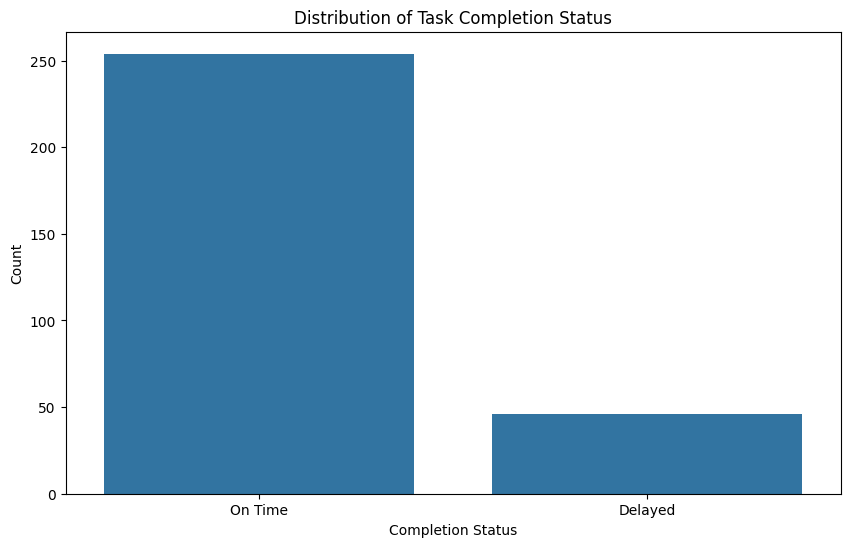

In [10]:
# Create a more descriptive label for the target variable
df['Completion_Status'] = df['On_Time'].map({1: 'On Time', 0: 'Delayed'})

# Visualize the distribution of completion status
plt.figure(figsize=(10, 6))
sns.countplot(x='Completion_Status', data=df)
plt.title('Distribution of Task Completion Status')
plt.xlabel('Completion Status')
plt.ylabel('Count')
plt.show()

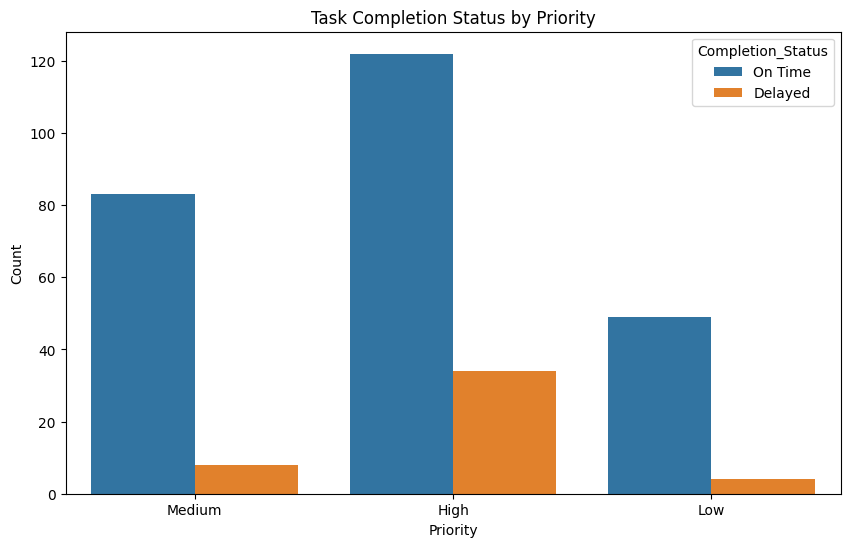

In [11]:
# Visualize the relationship between Priority and Completion Status
plt.figure(figsize=(10, 6))
sns.countplot(x='Priority', hue='Completion_Status', data=df)
plt.title('Task Completion Status by Priority')
plt.xlabel('Priority')
plt.ylabel('Count')
plt.show()

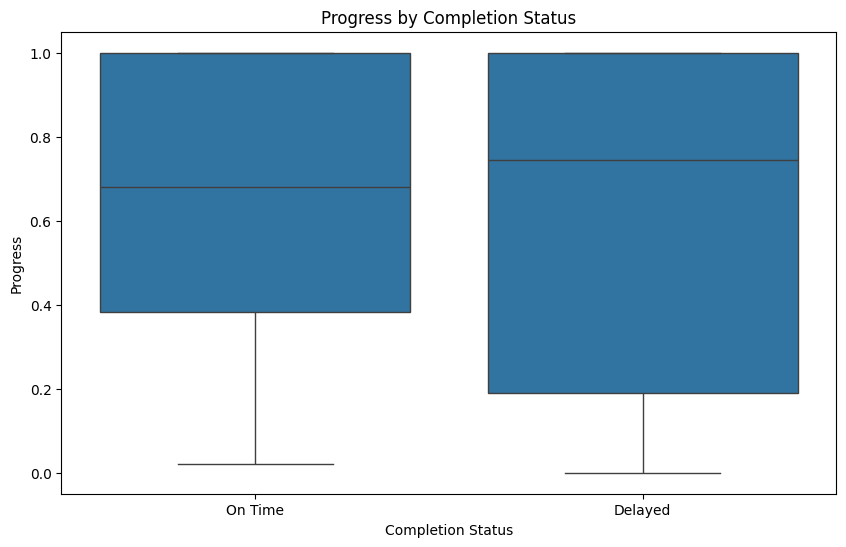

In [12]:
# Visualize the relationship between Progress and Completion Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Completion_Status', y='Progress', data=df)
plt.title('Progress by Completion Status')
plt.xlabel('Completion Status')
plt.ylabel('Progress')
plt.show()

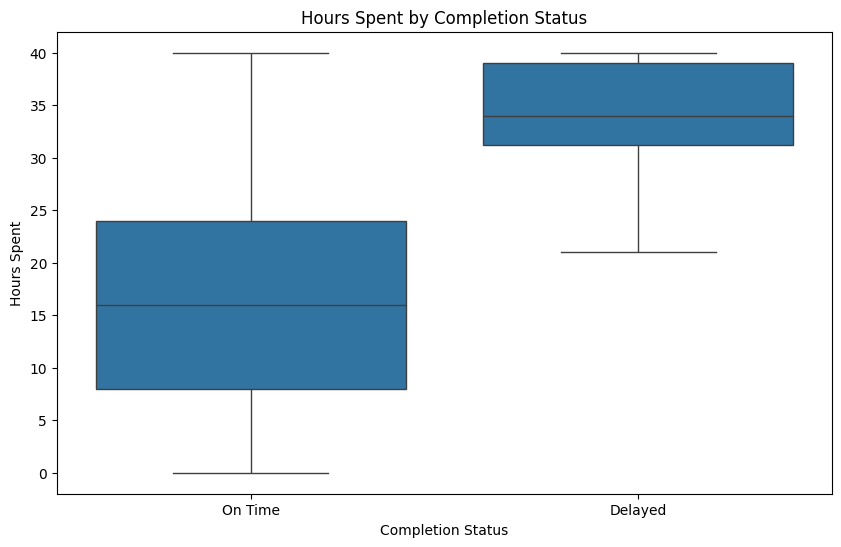

In [13]:
# Visualize the relationship between Hours Spent and Completion Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Completion_Status', y='Hours Spent', data=df)
plt.title('Hours Spent by Completion Status')
plt.xlabel('Completion Status')
plt.ylabel('Hours Spent')
plt.show()

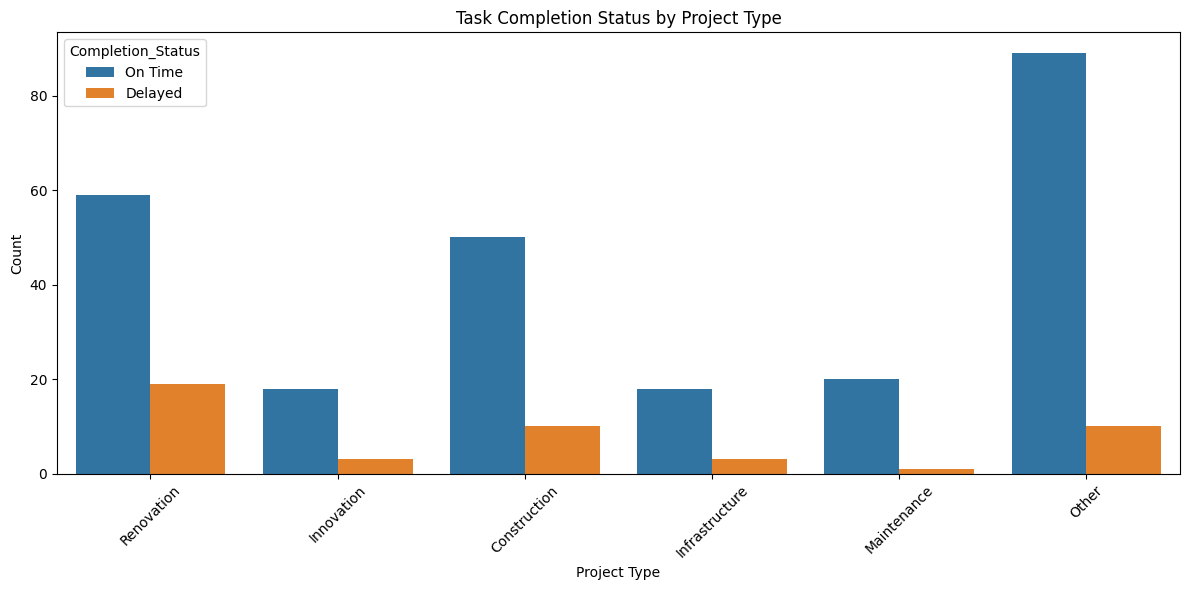

In [14]:
# Visualize the relationship between Project Type and Completion Status
plt.figure(figsize=(12, 6))
sns.countplot(x='Project Type', hue='Completion_Status', data=df)
plt.title('Task Completion Status by Project Type')
plt.xlabel('Project Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Data Preprocessing for Modeling

In [16]:
# Encode categorical variables
# Priority: Low, Medium, High
priority_encoder = LabelEncoder()
df['Priority_Encoded'] = priority_encoder.fit_transform(df['Priority'])

# Project Type
project_type_encoder = OneHotEncoder(sparse_output=False, drop='first')
project_type_encoded = project_type_encoder.fit_transform(df[['Project Type']])
project_type_df = pd.DataFrame(project_type_encoded, 
                              columns=[f'Project_Type_{i}' for i in range(project_type_encoded.shape[1])])
df = pd.concat([df.reset_index(drop=True), project_type_df], axis=1)

# Display the encoded values for Priority
print("Priority Encoding:")
for i, category in enumerate(priority_encoder.classes_):
    print(f"{category}: {i}")

# Display the encoded Project Types
print("\nProject Type Encoding:")
print(f"Reference category: {project_type_encoder.categories_[0][0]}")
for i, category in enumerate(project_type_encoder.categories_[0][1:]):
    print(f"{category}: Project_Type_{i}")

Priority Encoding:
High: 0
Low: 1
Medium: 2

Project Type Encoding:
Reference category: Construction
Infrastructure: Project_Type_0
Innovation: Project_Type_1
Maintenance: Project_Type_2
Other: Project_Type_3
Renovation: Project_Type_4


In [17]:
# Prepare features for modeling
# Get the Project Type column names
project_type_cols = [col for col in df.columns if col.startswith('Project_Type_')]

# Define features
features = ['Progress', 'Hours Spent', 'Priority_Encoded'] + project_type_cols
X = df[features]
y = df['On_Time']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Feature names: {features}")

Training set shape: (210, 8)
Testing set shape: (90, 8)
Feature names: ['Progress', 'Hours Spent', 'Priority_Encoded', 'Project_Type_0', 'Project_Type_1', 'Project_Type_2', 'Project_Type_3', 'Project_Type_4']


## 5. KNN Model Implementation

K-Nearest Neighbors (KNN) is used to compare tasks to historical ones and predict if a task will be completed on time or delayed.

KNN Accuracy: 0.8889

Classification Report:
              precision    recall  f1-score   support

     Delayed       0.75      0.43      0.55        14
     On Time       0.90      0.97      0.94        76

    accuracy                           0.89        90
   macro avg       0.83      0.70      0.74        90
weighted avg       0.88      0.89      0.88        90



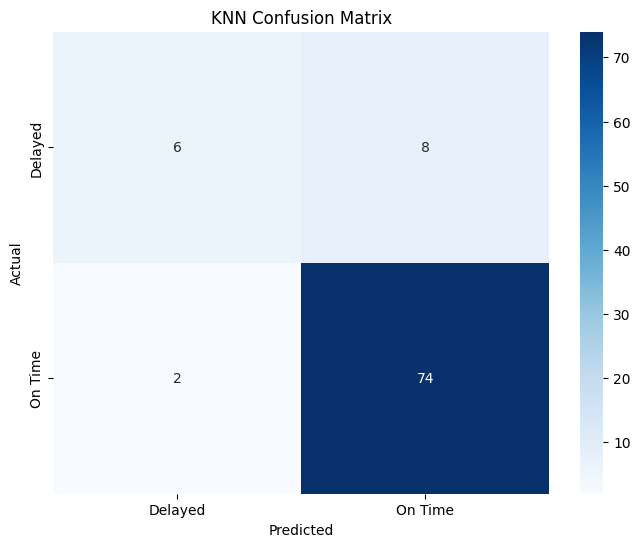

In [18]:
# Create a KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=['Delayed', 'On Time']))

# Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Delayed', 'On Time'],
            yticklabels=['Delayed', 'On Time'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')
plt.show()

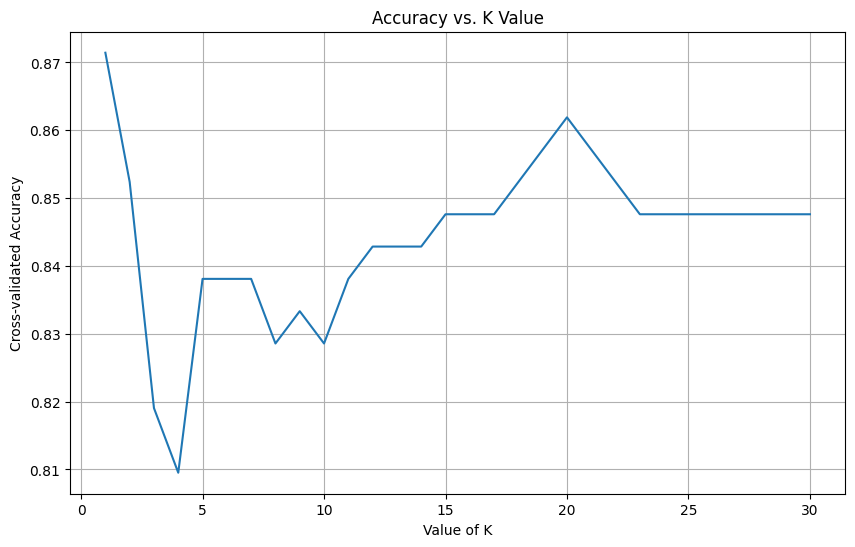

Best K value: 1
Best accuracy: 0.8714


In [19]:
# Find the optimal K value
k_range = range(1, 31)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

# Plot the K values vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K')
plt.ylabel('Cross-validated Accuracy')
plt.title('Accuracy vs. K Value')
plt.grid(True)
plt.show()

# Find the best K value
best_k = k_range[np.argmax(k_scores)]
print(f"Best K value: {best_k}")
print(f"Best accuracy: {max(k_scores):.4f}")

Best KNN Model Accuracy: 0.8667

Classification Report for Best KNN Model:
              precision    recall  f1-score   support

     Delayed       0.62      0.36      0.45        14
     On Time       0.89      0.96      0.92        76

    accuracy                           0.87        90
   macro avg       0.76      0.66      0.69        90
weighted avg       0.85      0.87      0.85        90



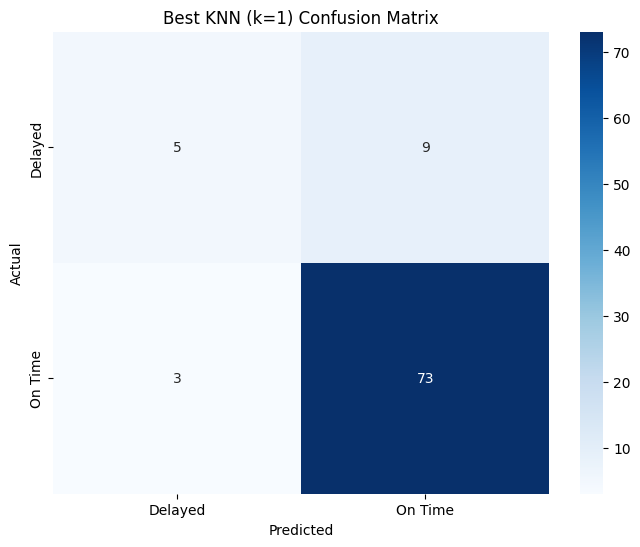

In [20]:
# Train the KNN model with the best K value
best_knn_model = KNeighborsClassifier(n_neighbors=best_k)
best_knn_model.fit(X_train_scaled, y_train)

# Make predictions with the best model
y_pred_best_knn = best_knn_model.predict(X_test_scaled)

# Get probability estimates
y_prob_best_knn = best_knn_model.predict_proba(X_test_scaled)

# Evaluate the best model
accuracy_best_knn = accuracy_score(y_test, y_pred_best_knn)
print(f"Best KNN Model Accuracy: {accuracy_best_knn:.4f}")

# Classification report for the best model
print("\nClassification Report for Best KNN Model:")
print(classification_report(y_test, y_pred_best_knn, target_names=['Delayed', 'On Time']))

# Confusion matrix for the best model
cm_best_knn = confusion_matrix(y_test, y_pred_best_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Delayed', 'On Time'],
            yticklabels=['Delayed', 'On Time'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Best KNN (k={best_k}) Confusion Matrix')
plt.show()

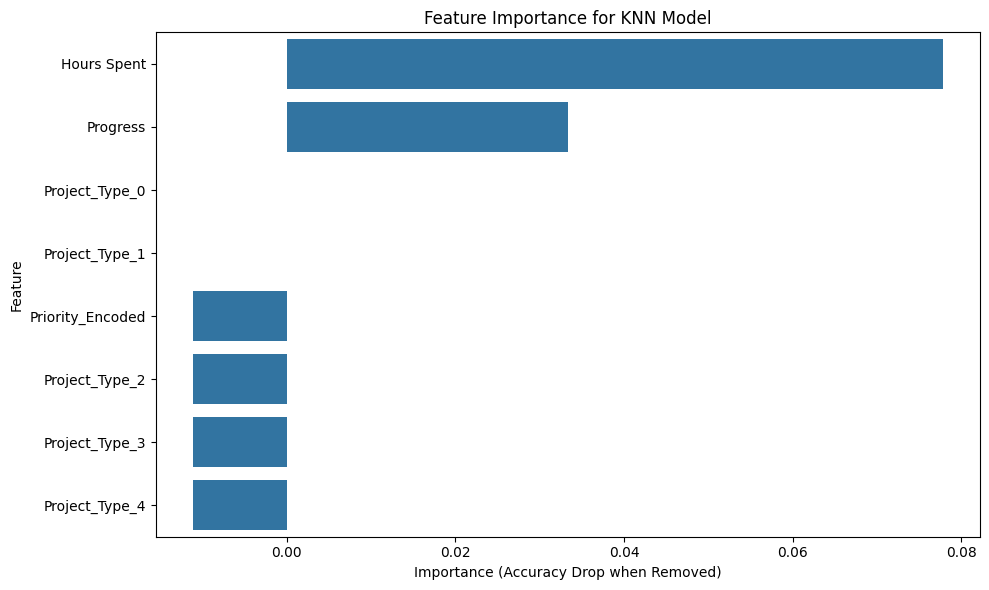

In [21]:
# Analyze which features are most important for KNN
# We'll use a simple approach: measure accuracy drop when each feature is removed

feature_importance = []
base_accuracy = accuracy_best_knn

for i, feature in enumerate(features):
    # Create a copy of the data without this feature
    X_train_reduced = np.delete(X_train_scaled, i, axis=1)
    X_test_reduced = np.delete(X_test_scaled, i, axis=1)
    
    # Train and evaluate a model without this feature
    knn_reduced = KNeighborsClassifier(n_neighbors=best_k)
    knn_reduced.fit(X_train_reduced, y_train)
    y_pred_reduced = knn_reduced.predict(X_test_reduced)
    accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
    
    # Calculate the importance as the drop in accuracy
    importance = base_accuracy - accuracy_reduced
    feature_importance.append(importance)

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for KNN Model')
plt.xlabel('Importance (Accuracy Drop when Removed)')
plt.tight_layout()
plt.show()

## 6. SVM Model Implementation

Support Vector Machine (SVM) is robust for small datasets and can classify tasks by priority alignment.

SVM Accuracy: 0.8778

Classification Report:
              precision    recall  f1-score   support

     Delayed       0.80      0.29      0.42        14
     On Time       0.88      0.99      0.93        76

    accuracy                           0.88        90
   macro avg       0.84      0.64      0.68        90
weighted avg       0.87      0.88      0.85        90



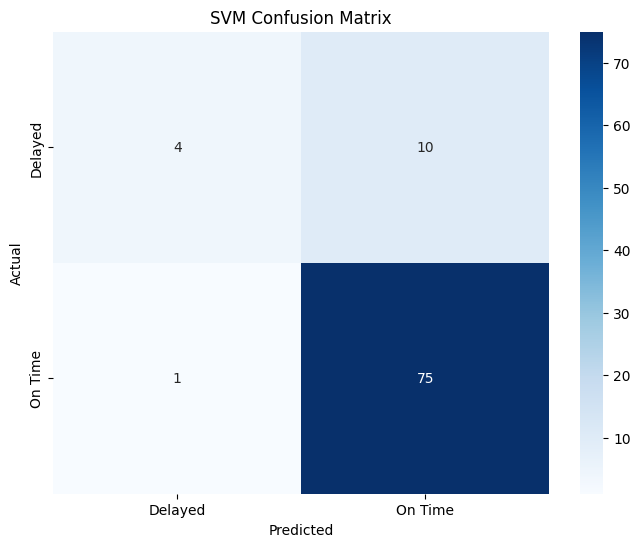

In [22]:
# Create an SVM classifier
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Delayed', 'On Time']))

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Delayed', 'On Time'],
            yticklabels=['Delayed', 'On Time'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

In [23]:
# Hyperparameter tuning for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly']
}

# Use stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the best model
best_svm_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best_svm = best_svm_model.predict(X_test_scaled)

# Get probability estimates
y_prob_best_svm = best_svm_model.predict_proba(X_test_scaled)

# Evaluate the best model
accuracy_best_svm = accuracy_score(y_test, y_pred_best_svm)
print(f"\nBest SVM Model Accuracy: {accuracy_best_svm:.4f}")

# Classification report for the best model
print("\nClassification Report for Best SVM Model:")
print(classification_report(y_test, y_pred_best_svm, target_names=['Delayed', 'On Time']))

Best parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation score: 0.9095

Best SVM Model Accuracy: 0.8889

Classification Report for Best SVM Model:
              precision    recall  f1-score   support

     Delayed       0.75      0.43      0.55        14
     On Time       0.90      0.97      0.94        76

    accuracy                           0.89        90
   macro avg       0.83      0.70      0.74        90
weighted avg       0.88      0.89      0.88        90



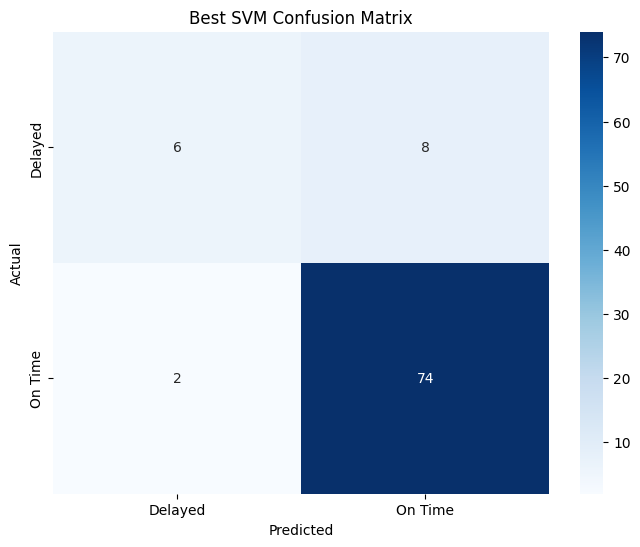

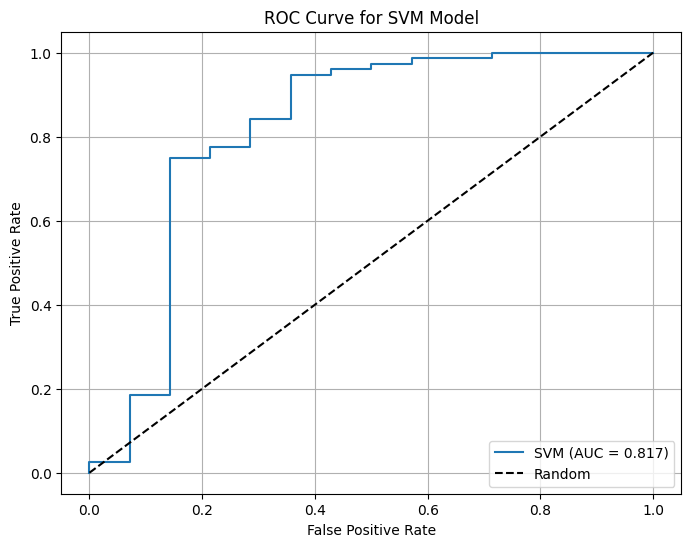

In [24]:
# Confusion matrix for the best SVM model
cm_best_svm = confusion_matrix(y_test, y_pred_best_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Delayed', 'On Time'],
            yticklabels=['Delayed', 'On Time'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Best SVM Confusion Matrix')
plt.show()

# ROC curve for SVM
y_prob_best_svm_positive = y_prob_best_svm[:, 1]  # Probability of being 'On Time'
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_best_svm_positive)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 7. Decision Tree Model Implementation (Optional)

Decision Trees provide explainable rules for predicting task delays.

Decision Tree Accuracy: 0.9222

Classification Report:
              precision    recall  f1-score   support

     Delayed       0.89      0.57      0.70        14
     On Time       0.93      0.99      0.96        76

    accuracy                           0.92        90
   macro avg       0.91      0.78      0.83        90
weighted avg       0.92      0.92      0.92        90



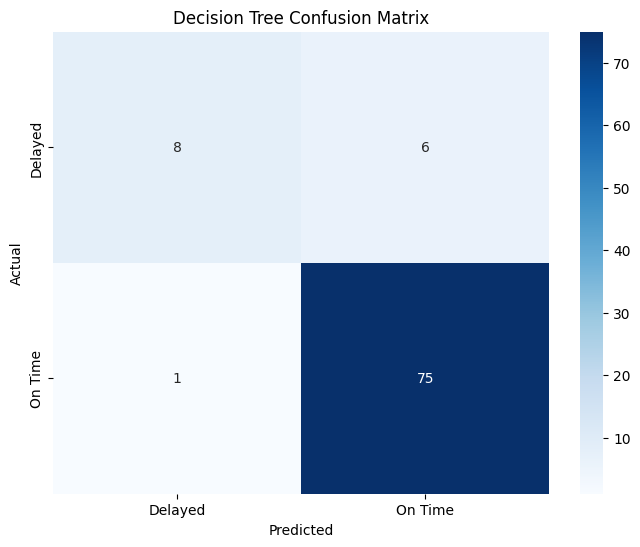

In [26]:
# Create a Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['Delayed', 'On Time']))

# Confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Delayed', 'On Time'],
            yticklabels=['Delayed', 'On Time'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Confusion Matrix')
plt.show()

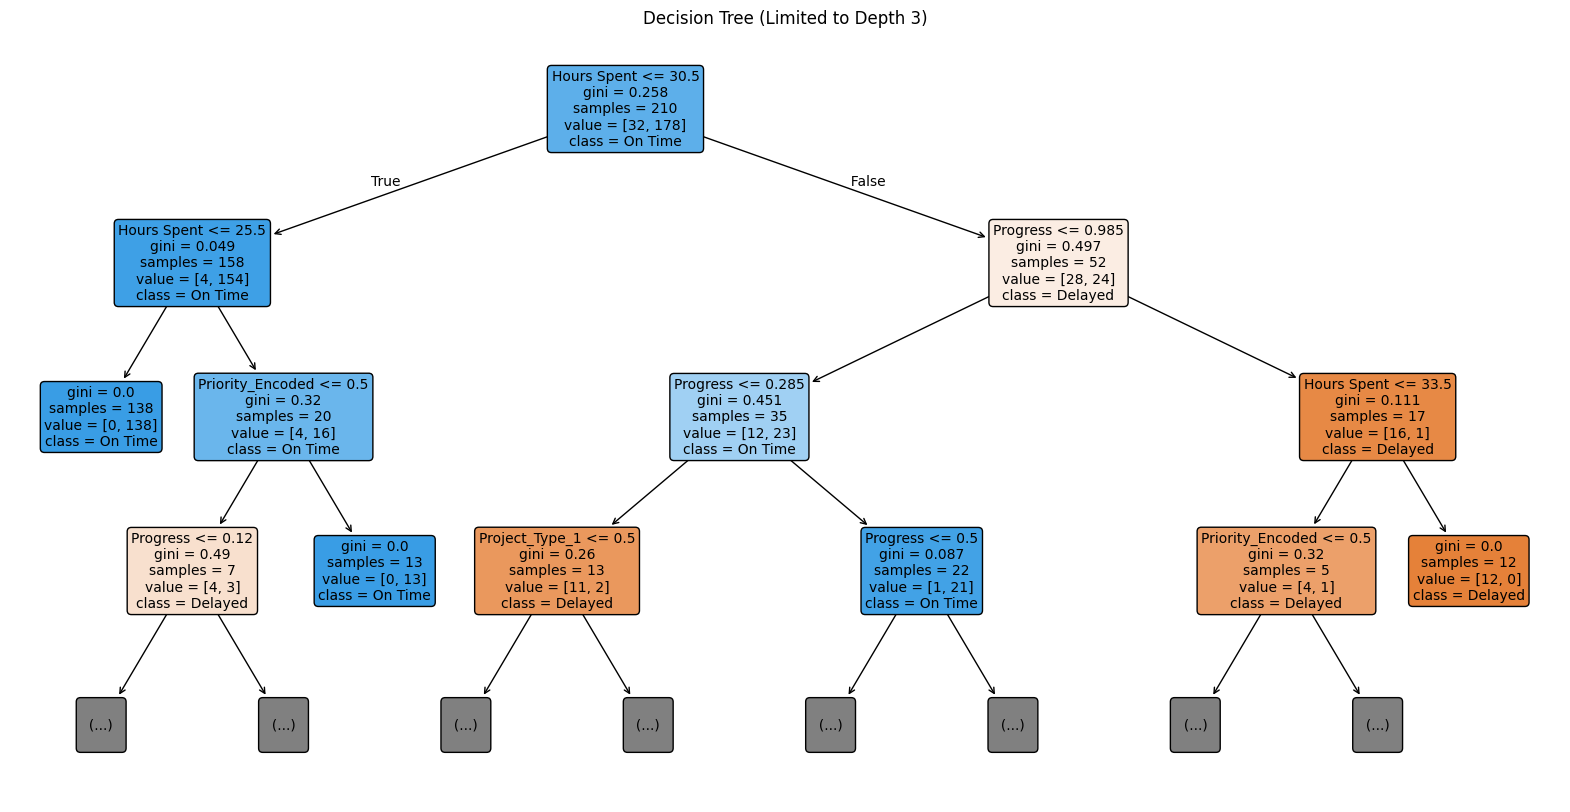

In [27]:
# Visualize the Decision Tree (limited to max_depth=3 for better visualization)
plt.figure(figsize=(20, 10))
plot_tree(dt_model, max_depth=3, feature_names=features, 
          class_names=['Delayed', 'On Time'], 
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree (Limited to Depth 3)')
plt.show()

In [28]:
# Print the decision rules
tree_rules = export_text(dt_model, feature_names=features)
print("Decision Tree Rules:")
print(tree_rules)

Decision Tree Rules:
|--- Hours Spent <= 30.50
|   |--- Hours Spent <= 25.50
|   |   |--- class: 1
|   |--- Hours Spent >  25.50
|   |   |--- Priority_Encoded <= 0.50
|   |   |   |--- Progress <= 0.12
|   |   |   |   |--- class: 0
|   |   |   |--- Progress >  0.12
|   |   |   |   |--- Progress <= 1.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Progress >  1.00
|   |   |   |   |   |--- class: 0
|   |   |--- Priority_Encoded >  0.50
|   |   |   |--- class: 1
|--- Hours Spent >  30.50
|   |--- Progress <= 0.99
|   |   |--- Progress <= 0.28
|   |   |   |--- Project_Type_1 <= 0.50
|   |   |   |   |--- Project_Type_3 <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Project_Type_3 >  0.50
|   |   |   |   |   |--- Progress <= 0.11
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Progress >  0.11
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- Project_Type_1 >  0.50
|   |   |   |   |--- class: 1
|   |   |--- Progress >  0.28
|   |   |   |--- Progre

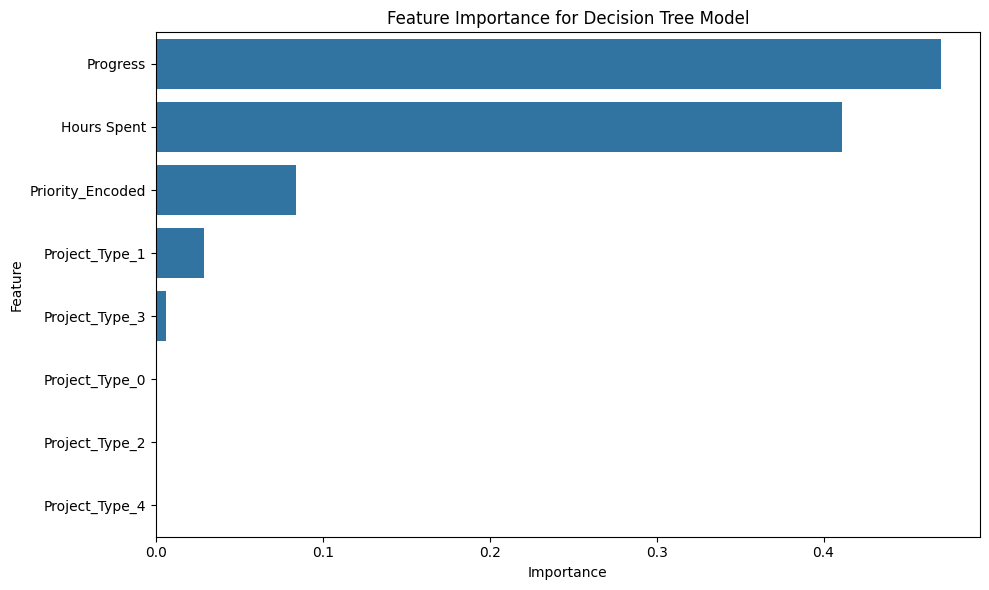

In [29]:
# Feature importance for Decision Tree
dt_feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': dt_model.feature_importances_
})

# Sort by importance
dt_feature_importance = dt_feature_importance.sort_values('Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=dt_feature_importance)
plt.title('Feature Importance for Decision Tree Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [30]:
# Hyperparameter tuning for Decision Tree
param_grid = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Use the best model
best_dt_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best_dt = best_dt_model.predict(X_test)

# Get probability estimates
y_prob_best_dt = best_dt_model.predict_proba(X_test)

# Evaluate the best model
accuracy_best_dt = accuracy_score(y_test, y_pred_best_dt)
print(f"\nBest Decision Tree Model Accuracy: {accuracy_best_dt:.4f}")

# Classification report for the best model
print("\nClassification Report for Best Decision Tree Model:")
print(classification_report(y_test, y_pred_best_dt, target_names=['Delayed', 'On Time']))

Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation score: 0.9524

Best Decision Tree Model Accuracy: 0.9222

Classification Report for Best Decision Tree Model:
              precision    recall  f1-score   support

     Delayed       0.82      0.64      0.72        14
     On Time       0.94      0.97      0.95        76

    accuracy                           0.92        90
   macro avg       0.88      0.81      0.84        90
weighted avg       0.92      0.92      0.92        90



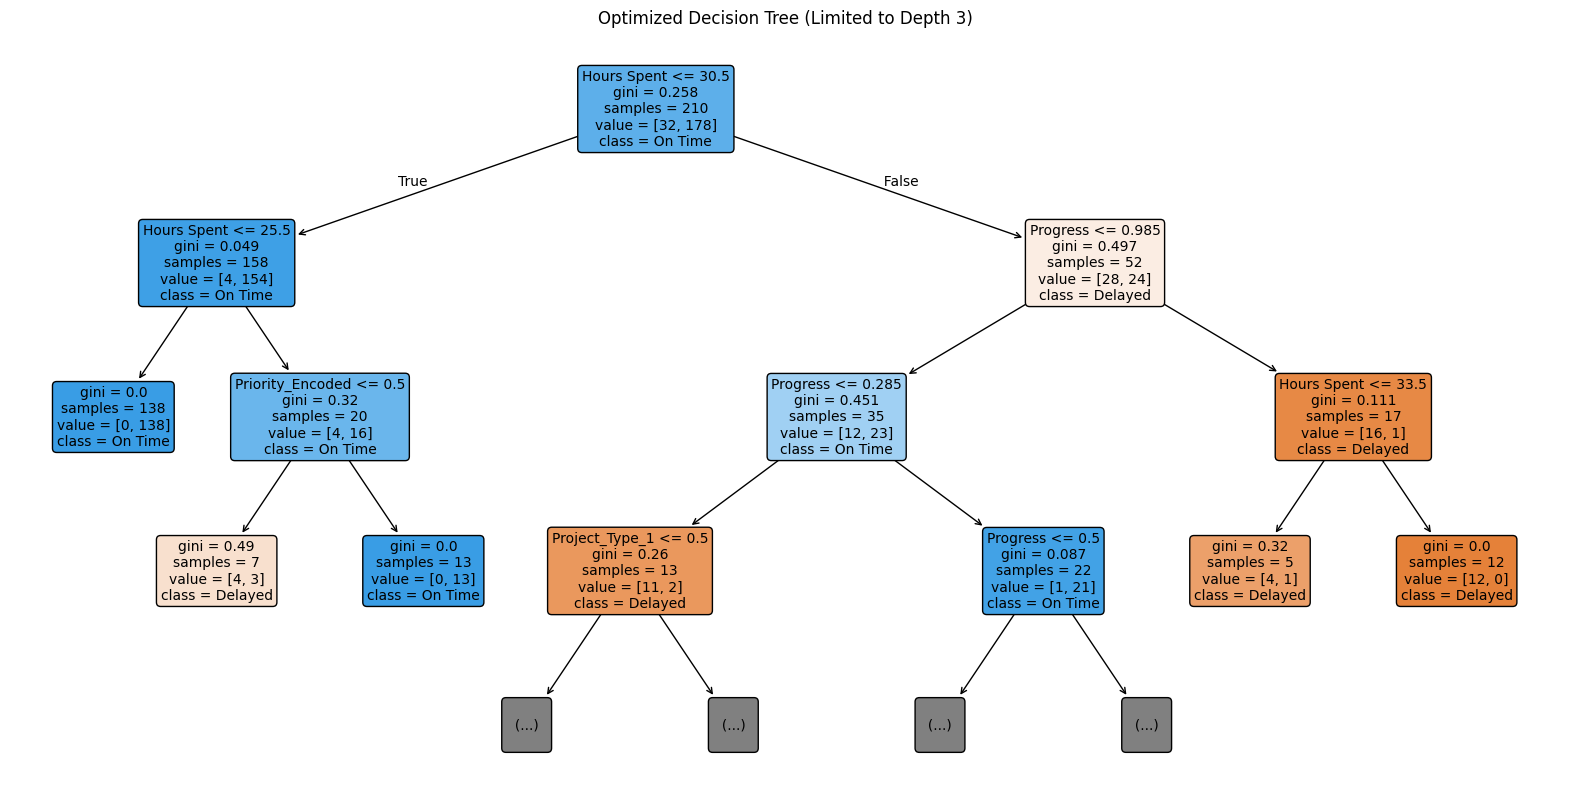

Optimized Decision Tree Rules:
|--- Hours Spent <= 30.50
|   |--- Hours Spent <= 25.50
|   |   |--- class: 1
|   |--- Hours Spent >  25.50
|   |   |--- Priority_Encoded <= 0.50
|   |   |   |--- class: 0
|   |   |--- Priority_Encoded >  0.50
|   |   |   |--- class: 1
|--- Hours Spent >  30.50
|   |--- Progress <= 0.99
|   |   |--- Progress <= 0.28
|   |   |   |--- Project_Type_1 <= 0.50
|   |   |   |   |--- Hours Spent <= 33.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Hours Spent >  33.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- Project_Type_1 >  0.50
|   |   |   |   |--- class: 1
|   |   |--- Progress >  0.28
|   |   |   |--- Progress <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Progress >  0.50
|   |   |   |   |--- class: 1
|   |--- Progress >  0.99
|   |   |--- Hours Spent <= 33.50
|   |   |   |--- class: 0
|   |   |--- Hours Spent >  33.50
|   |   |   |--- class: 0



In [31]:
# Visualize the optimized Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt_model, max_depth=3, feature_names=features, 
          class_names=['Delayed', 'On Time'], 
          filled=True, rounded=True, fontsize=10)
plt.title('Optimized Decision Tree (Limited to Depth 3)')
plt.show()

# Print the optimized decision rules
best_tree_rules = export_text(best_dt_model, feature_names=features)
print("Optimized Decision Tree Rules:")
print(best_tree_rules)

## 8. Model Comparison

Compare the performance of all models to select the best one for task prioritization.

In [32]:
# Compare model performance
models = ['KNN', 'Best KNN', 'SVM', 'Best SVM', 'Decision Tree', 'Best Decision Tree']
accuracies = [accuracy_knn, accuracy_best_knn, accuracy_svm, accuracy_best_svm, accuracy_dt, accuracy_best_dt]

# Create a DataFrame for comparison
model_comparison = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies
})

# Sort by accuracy
model_comparison = model_comparison.sort_values('Accuracy', ascending=False)

# Display the comparison
model_comparison

,Model,Accuracy
4,Decision Tree,0.922222
5,Best Decision Tree,0.922222
3,Best SVM,0.888889
0,KNN,0.888889
2,SVM,0.877778
1,Best KNN,0.866667


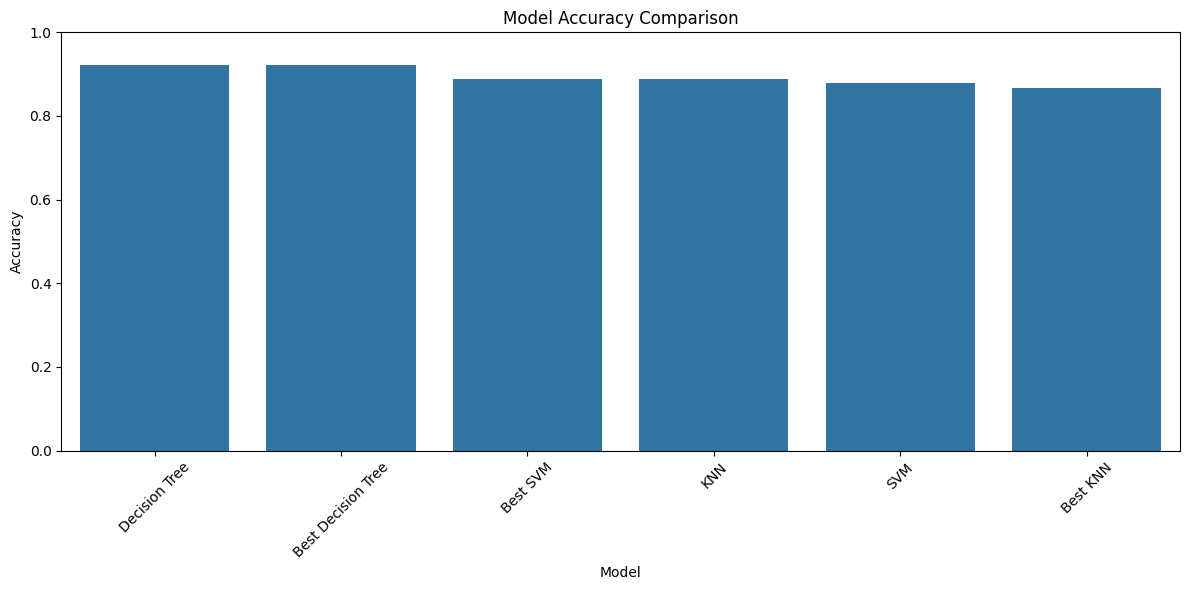

In [33]:
# Visualize model comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=model_comparison)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

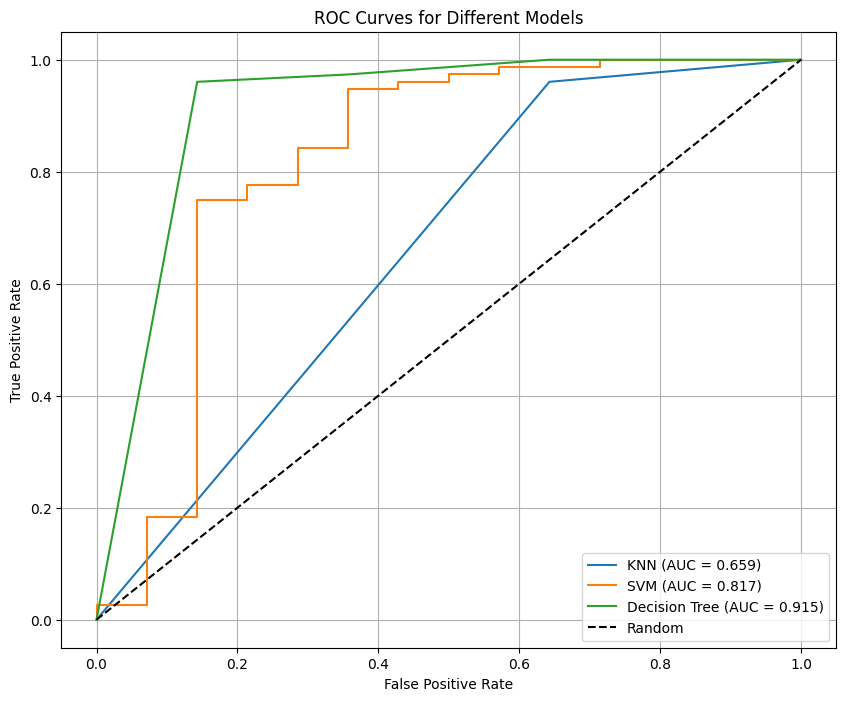

In [34]:
# Compare ROC curves
plt.figure(figsize=(10, 8))

# KNN ROC curve
y_prob_best_knn_positive = y_prob_best_knn[:, 1]  # Probability of being 'On Time'
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_best_knn_positive)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.3f})')

# SVM ROC curve
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.3f})')

# Decision Tree ROC curve
y_prob_best_dt_positive = y_prob_best_dt[:, 1]  # Probability of being 'On Time'
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_best_dt_positive)
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')

# Random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 9. Task Prioritization System

Create a system to prioritize tasks and generate alerts for misaligned priorities.

In [43]:
best_model = best_svm_model 

# Function to calculate task risk score
def calculate_task_risk_score(task_data, model=best_model, scaler=scaler):
    # Extract features
    features_list = []
    
    # Extract numerical features
    progress = task_data['Progress']
    hours_spent = task_data['Hours Spent']
    
    # Encode priority
    priority = task_data['Priority']
    priority_encoded = priority_encoder.transform([priority])[0]
    
    # Encode project type
    project_type = task_data['Project Type']
    project_type_encoded = project_type_encoder.transform([[project_type]])[0]
    
    # Create feature array
    features_array = np.array([[progress, hours_spent, priority_encoded] + list(project_type_encoded)])
    
    # Scale features
    features_scaled = scaler.transform(features_array)
    
    # Get probability of delay (1 - probability of being on time)
    delay_probability = 1 - model.predict_proba(features_scaled)[0][1]
    
    # Calculate risk score (0-100)
    risk_score = delay_probability * 100
    
    return risk_score

# Function to check for priority misalignment
def check_priority_misalignment(task_data, risk_threshold=50):
    priority = task_data['Priority']
    progress = task_data['Progress']
    risk_score = task_data['Risk Score']
    
    alerts = []
    
    # Check for high priority tasks with high risk
    if priority == 'High' and risk_score > risk_threshold:
        alerts.append(f"High Priority task with {risk_score:.1f}% risk of delay")
    
    # Check for high priority tasks with low progress
    if priority == 'High' and progress < 0.3:
        alerts.append(f"High Priority task with only {progress*100:.1f}% progress")
    
    # Check for medium priority tasks with very high risk
    if priority == 'Medium' and risk_score > 70:
        alerts.append(f"Medium Priority task with {risk_score:.1f}% risk of delay")
    
    # Check for low priority tasks with low risk but high progress
    if priority == 'Low' and risk_score < 30 and progress > 0.7:
        alerts.append(f"Low Priority task with {progress*100:.1f}% progress (potential resource misallocation)")
    
    return alerts

In [44]:
# Apply the risk scoring to all tasks
df['Risk Score'] = df.apply(lambda row: calculate_task_risk_score({
    'Progress': row['Progress'],
    'Hours Spent': row['Hours Spent'],
    'Priority': row['Priority'],
    'Project Type': row['Project Type']
}), axis=1)

# Check for priority misalignments
df['Alerts'] = df.apply(lambda row: check_priority_misalignment({
    'Priority': row['Priority'],
    'Progress': row['Progress'],
    'Risk Score': row['Risk Score']
}), axis=1)

# Add a flag for tasks with alerts
df['Has Alerts'] = df['Alerts'].apply(lambda x: len(x) > 0)

# Display tasks with alerts
tasks_with_alerts = df[df['Has Alerts']][[
    'Task ID', 'Project Type', 'Priority', 'Progress', 'Hours Spent', 'Task Status', 'Risk Score', 'Alerts'
]]

print(f"Number of tasks with alerts: {len(tasks_with_alerts)}")
tasks_with_alerts.head(10)

c:\Users\USER\Desktop\ml project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\USER\Desktop\ml project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\USER\Desktop\ml project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\USER\Desktop\ml project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\USER\Desktop\ml project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feat

Number of tasks with alerts: 85


c:\Users\USER\Desktop\ml project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\USER\Desktop\ml project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\USER\Desktop\ml project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\USER\Desktop\ml project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\USER\Desktop\ml project\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feat

,Task ID,Project Type,Priority,Progress,Hours Spent,Task Status,Risk Score,Alerts
6,T001,Construction,Low,1.00,7,Completed,6.773006,[Low Priority task with 100.0% progress (poten...
14,T003,Maintenance,High,0.04,0,Pending,12.536354,[High Priority task with only 4.0% progress]
15,T001,Renovation,Low,1.00,9,Completed,7.546967,[Low Priority task with 100.0% progress (poten...
16,T002,Renovation,Medium,1.00,40,Completed,72.510514,[Medium Priority task with 72.5% risk of delay]
17,T003,Renovation,High,0.07,40,In Progress,79.265657,"[High Priority task with 79.3% risk of delay, ..."
20,T003,Other,Low,0.92,10,Pending,6.006620,[Low Priority task with 92.0% progress (potent...
26,T003,Other,Low,0.97,26,Pending,3.391530,[Low Priority task with 97.0% progress (potent...
27,T001,Other,High,0.10,32,Pending,28.849573,[High Priority task with only 10.0% progress]
32,T003,Renovation,High,0.02,1,Pending,7.824098,[High Priority task with only 2.0% progress]
34,T002,Construction,High,1.00,40,Completed,72.509037,[High Priority task with 72.5% risk of delay]


## 10. Task Prioritization Recommendations

Based on our analysis, we can provide recommendations for task prioritization.

In [42]:
# Generate task prioritization recommendations
print("Task Prioritization Recommendations:\n")

# 1. High-risk high-priority tasks
high_risk_high_priority = df[(df['Priority'] == 'High') & (df['Risk Score'] > 60)]
if len(high_risk_high_priority) > 0:
    print("1. High-Risk High-Priority Tasks (Immediate Attention Required):")
    for _, task in high_risk_high_priority.iterrows():
        print(f"   - Task ID: {task['Task ID']}, Project: {task['Project Type']}, Progress: {task['Progress']*100:.1f}%, Risk Score: {task['Risk Score']:.1f}%")
        for alert in task['Alerts']:
            print(f"     * {alert}")
    print()

# 2. Medium-risk high-priority tasks
medium_risk_high_priority = df[(df['Priority'] == 'High') & (df['Risk Score'] > 30) & (df['Risk Score'] <= 60)]
if len(medium_risk_high_priority) > 0:
    print("2. Medium-Risk High-Priority Tasks (Close Monitoring Required):")
    for _, task in medium_risk_high_priority.iterrows():
        print(f"   - Task ID: {task['Task ID']}, Project: {task['Project Type']}, Progress: {task['Progress']*100:.1f}%, Risk Score: {task['Risk Score']:.1f}%")
    print()

# 3. High-risk medium-priority tasks
high_risk_medium_priority = df[(df['Priority'] == 'Medium') & (df['Risk Score'] > 70)]
if len(high_risk_medium_priority) > 0:
    print("3. High-Risk Medium-Priority Tasks (Consider Reprioritizing):")
    for _, task in high_risk_medium_priority.iterrows():
        print(f"   - Task ID: {task['Task ID']}, Project: {task['Project Type']}, Progress: {task['Progress']*100:.1f}%, Risk Score: {task['Risk Score']:.1f}%")
    print()

# 4. Low-risk low-priority tasks with high progress
low_risk_low_priority_high_progress = df[(df['Priority'] == 'Low') & (df['Risk Score'] < 30) & (df['Progress'] > 0.7)]
if len(low_risk_low_priority_high_progress) > 0:
    print("4. Low-Priority Tasks with High Progress (Potential Resource Misallocation):")
    for _, task in low_risk_low_priority_high_progress.iterrows():
        print(f"   - Task ID: {task['Task ID']}, Project: {task['Project Type']}, Progress: {task['Progress']*100:.1f}%, Risk Score: {task['Risk Score']:.1f}%")
    print()

Task Prioritization Recommendations:

1. High-Risk High-Priority Tasks (Immediate Attention Required):
   - Task ID: T003, Project: Renovation, Progress: 7.0%, Risk Score: 79.3%
     * High Priority task with 79.3% risk of delay
     * High Priority task with only 7.0% progress
   - Task ID: T002, Project: Construction, Progress: 100.0%, Risk Score: 72.5%
     * High Priority task with 72.5% risk of delay
   - Task ID: T002, Project: Innovation, Progress: 100.0%, Risk Score: 72.5%
     * High Priority task with 72.5% risk of delay
   - Task ID: T001, Project: Other, Progress: 100.0%, Risk Score: 72.5%
     * High Priority task with 72.5% risk of delay
   - Task ID: T003, Project: Renovation, Progress: 100.0%, Risk Score: 72.5%
     * High Priority task with 72.5% risk of delay
   - Task ID: T003, Project: Construction, Progress: 21.0%, Risk Score: 86.4%
     * High Priority task with 86.4% risk of delay
     * High Priority task with only 21.0% progress
   - Task ID: T001, Project: Oth